In [1]:
import requests
from IPython.core.display import HTML
styles = requests.get(
   "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

### <div class='exercise'> Data Pre-Processing and Baseline Modelling </div>
---

Naive k-NN Model Score: 0.5
Baseline Logistic Regression Score: 0.7336800791346246


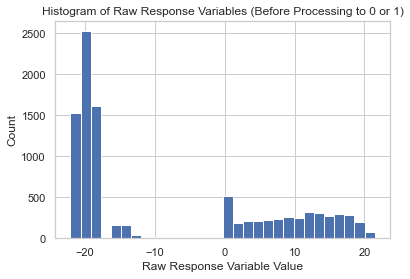

In [2]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.impute import KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance

np.random.seed(109)

X_data = pd.read_csv('NHANESI_X.csv')
y_data = pd.read_csv('NHANESI_y.csv')

X_data = X_data.drop('Unnamed: 0', axis = 1)
y_data = y_data.drop('Unnamed: 0', axis = 1)

X_data = pd.get_dummies(X_data, drop_first=True, columns=["Race"])
X_data = X_data.rename(columns={"Race_2.0": "Other", "Race_3.0": "Black"})

plt.hist(x=y_data.values, bins=30)
plt.xlabel("Raw Response Variable Value")
plt.ylabel("Count")
plt.title("Histogram of Raw Response Variables (Before Processing to 0 or 1)")

y_data['y'] = (abs(y_data['y'])>=18)*1

# Splitting the data first
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2,
                                                    random_state = 109, shuffle=True, 
                                                    stratify=y_data['y'])

X_train_good = X_train.copy()
X_test_good = X_test.copy()

# Resetting variable values to aid in interpretabiltiy 
X_train_good['Sex'] = X_train['Sex']-1
X_test_good['Sex'] = X_test['Sex']-1

X_train = X_train_good
X_test = X_test_good

non_categorical = ['Age', 'Diastolic BP', 'Poverty index', 'Red blood cells', 'Sedimentation rate', 'Serum Albumin', 'Serum Cholesterol', 'Serum Iron', 'Serum Magnesium', 
                   'Serum Protein', 'Systolic BP', 'TIBC', 'TS', 'White blood cells', 'BMI', 'Pulse pressure']
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Standardizing data to aid in model convergence and performance
scaler = StandardScaler()
X_train_scaled[non_categorical] = scaler.fit_transform(X_train[non_categorical])
X_test_scaled[non_categorical] = scaler.fit_transform(X_test[non_categorical])

# Imputing X_data with KNN imputer, n_neighbors = 1 to handle NaN values
imputer = KNNImputer(n_neighbors=1)
X_train_impute = imputer.fit_transform(X_train_scaled)
X_test_impute = imputer.fit_transform(X_test_scaled)

# Turning ndarray into DF; resetting column names
X_train_impute = pd.DataFrame(X_train_impute, columns = X_data.columns)
X_test_impute = pd.DataFrame(X_test_impute, columns = X_data.columns)

y_train = pd.DataFrame(y_train.values, columns = y_data.columns)
y_test = pd.DataFrame(y_test.values, columns = y_data.columns)

# Baseline KNN model (n = DF size, so essentially mean) on imputed data
baseline_kNN_model = KNeighborsClassifier(n_neighbors=len(X_train_impute)).fit(X_train_impute,y_train.values.ravel())
y_pred = baseline_kNN_model.predict(X_test_impute)

baseline_kNN_model_accuracy = roc_auc_score(y_test, y_pred)
print("Naive k-NN Model Score:", baseline_kNN_model_accuracy)

# Logistic regression model on dropped data
logit_base = LogisticRegression(max_iter=5000).fit(X_train_impute,y_train.values.ravel())
y_pred = logit_base.predict(X_test_impute)

logit_base_test_accuracy = roc_auc_score(y_test, y_pred)
print("Baseline Logistic Regression Score:", logit_base_test_accuracy)

### <div class="exercise"> k-NN Performance </div>

In [3]:
k_list = [10,25,50,100,120,150,200,250,300,500]
validation_error = []
training_error = []

for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_impute, y_train.values.ravel())
    
    accuracies = cross_validate(knn, X_train_impute, y_train.values.ravel(), scoring = "roc_auc", cv=5, return_train_score=True)

    # Compute the validation errors got after cross validation
    train_acc = accuracies['train_score'].mean()
    val_acc =  accuracies['test_score'].mean()
    
    # Append the Accuracies to their respective lists     
    validation_error.append(val_acc)
    training_error.append(train_acc)
    
    

In [5]:
max_val = max(validation_error)
k = k_list[validation_error.index(max_val)]
print(f"Best Neighbors: {k}")

Best Neighbors: 100


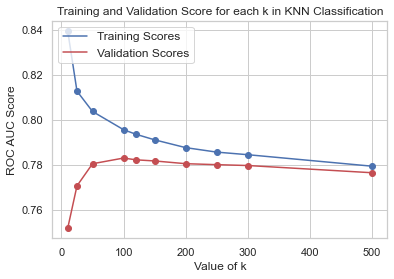

In [6]:
# scatter plot and line for training acc
plt.scatter(k_list,training_error, color="b")
plt.plot(k_list,training_error, color="b", label="Training Scores")

# scatter plot and line for val acc
plt.scatter(k_list,validation_error, color="r")
plt.plot(k_list,validation_error, color="r", label="Validation Scores")

# Labels, axes, and legend
plt.title("Training and Validation Score for each k in KNN Classification")
plt.xlabel("Value of k")
plt.ylabel("ROC AUC Score")
plt.legend(loc = 'upper left', fontsize = 12)
plt.savefig("Vineet/Knn_Training", bbox_inches = "tight")

In [7]:
best_knn = KNeighborsClassifier(n_neighbors=k)
best_knn.fit(X_train_impute, y_train.values.ravel())

y_test_pred = best_knn.predict(X_test_impute)
best_knn_test_acccuracy = roc_auc_score(y_test, y_test_pred)

print("The overall test classification ROC AUC score is:", round(best_knn_test_acccuracy,6))

The overall test classification ROC AUC score is: 0.684802


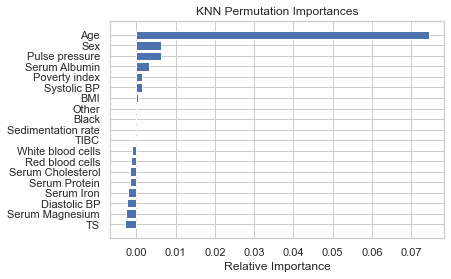

In [8]:
from sklearn.inspection import permutation_importance
features = X_train.columns
importances = permutation_importance(best_knn, X_train_impute, y_train)
indices = np.argsort(importances['importances_mean'])

plt.title("KNN Permutation Importances")
plt.barh(range(len(indices)), importances['importances_mean'][indices], color = "b", align = "center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.savefig("Vineet/Knn_Permutation", bbox_inches = "tight")
plt.show()

### <div class="exercise"> Logistic Regression Lasso </div>

In [9]:
logit_lasso = LogisticRegression(penalty = 'l1', max_iter = 500, solver ='saga')

logit_lasso.fit(X_train_impute, y_train.values.ravel())
    
y_pred_train = logit_lasso.predict(X_train_impute)
    
y_pred_test = logit_lasso.predict(X_test_impute)
    
logit_lasso_train_auc_score = roc_auc_score(y_train, y_pred_train)
logit_lasso_test_auc_score = roc_auc_score(y_test, y_pred_test)

print(f"Logistic regression lasso train AUC score: {logit_lasso_train_auc_score}")
print(f"Logistic regression lasso test AUC score: {logit_lasso_test_auc_score}")

print(f"The y-intercept for logistic regression lasso: {logit_lasso.intercept_[0]:.3f}")
print(f"The coefficients for logistic regression lasso: {logit_lasso.coef_[0]}")

Logistic regression lasso train AUC score: 0.7351194139092766
Logistic regression lasso test AUC score: 0.7336800791346246
The y-intercept for logistic regression lasso: 0.199
The coefficients for logistic regression lasso: [-0.92255376  0.          0.15936109  0.02251629 -0.11200395  0.27727804
  0.01957893 -0.07215905  0.10518919 -0.22725699  0.75087519 -0.14562643
 -0.0347954   0.07342501 -0.16603959  0.07118891 -0.07476962 -0.42698489
 -0.23868145]


### <div class="exercise"> CV Logistic Regression with Lasso </div>

In [10]:
Cs_vals = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]

logit_lasso_CV = LogisticRegressionCV(penalty = 'l1', scoring="roc_auc", Cs=Cs_vals, cv = 5, max_iter = 2000, solver ='liblinear')

logit_lasso_CV.fit(X_train_impute, y_train.values.ravel())
    
y_pred_train_CV = logit_lasso_CV.predict(X_train_impute)
    
y_pred_test_CV = logit_lasso_CV.predict(X_test_impute)
    
logit_lasso_train_auc_score_CV = roc_auc_score(y_train, y_pred_train_CV)
logit_lasso_test_auc_score_CV = roc_auc_score(y_test, y_pred_test_CV)

print(f"Logistic regression CV lasso train auc score: {logit_lasso_train_auc_score_CV}")
print(f"Logistic regression CV lasso test auc score: {logit_lasso_test_auc_score_CV}")

print(f"The y-intercept for logistic regression lasso CV: {logit_lasso_CV.intercept_[0]:.3f}")
print(f"The coefficients for logistic regression lasso CV: {logit_lasso_CV.coef_[0]}")

Logistic regression CV lasso train auc score: 0.7348093684359405
Logistic regression CV lasso test auc score: 0.7336800791346246
The y-intercept for logistic regression lasso CV: 0.199
The coefficients for logistic regression lasso CV: [-0.92453534 -0.10669635  0.15983854  0.02325577 -0.11274331  0.27842407
  0.02081819 -0.09687409  0.10573163 -0.22761832  0.75482299  0.05529113
 -0.02636336  0.09952687 -0.16743471  0.07203061 -0.22335936 -0.43306658
 -0.30614562]


### <div class="exercise"> Logistic Regression with Ridge Regularization </div>

In [11]:
logit_ridge = LogisticRegression(penalty = 'l2', max_iter = 10000, solver = 'lbfgs')

logit_ridge.fit(X_train_impute, y_train.values.ravel())
    
y_pred_train = logit_ridge.predict(X_train_impute)
    
y_pred_test = logit_ridge.predict(X_test_impute)
    
logit_ridge_train_auc_score = roc_auc_score(y_train, y_pred_train)
logit_ridge_test_auc_score = roc_auc_score(y_test, y_pred_test)

print(f"Logistic regression ridge train auc score: {logit_ridge_train_auc_score}")
print(f"Logistic regression ridge test auc score: {logit_ridge_test_auc_score}")

print(f"The y-intercept for logistic regression ridge: {logit_ridge.intercept_[0]:.3f}")
print(f"The coefficients for logistic regression ridge: {logit_ridge.coef_[0]}")

Logistic regression ridge train auc score: 0.734855138478995
Logistic regression ridge test auc score: 0.7336800791346246
The y-intercept for logistic regression ridge: 0.199
The coefficients for logistic regression ridge: [-0.92318506 -0.02579083  0.15981013  0.02318375 -0.11267211  0.27826102
  0.02065683 -0.09678891  0.10565945 -0.22759902  0.75256332 -0.0975836
 -0.02586671  0.09935178 -0.16702181  0.0719631  -0.1109567  -0.42980502
 -0.28612371]


### <div class="exercise"> CV Logistic Regression with Ridge Regularization </div>

In [12]:
Cs_vals = [1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4]

logit_ridge_CV = LogisticRegressionCV(penalty = 'l2', scoring="roc_auc", Cs=Cs_vals, max_iter = 10000, cv = 5, solver = 'lbfgs')

logit_ridge_CV.fit(X_train_impute, y_train.values.ravel())
    
y_pred_train_CV = logit_ridge.predict(X_train_impute)
    
y_pred_test_CV = logit_ridge.predict(X_test_impute)
    
logit_ridge_train_auc_score_CV = roc_auc_score(y_train, y_pred_train_CV)
logit_ridge_test_auc_score_CV = roc_auc_score(y_test, y_pred_test_CV)

print(f"Logistic regression CV ridge train auc score: {logit_ridge_train_auc_score_CV}")
print(f"Logistic regression CV ridge test auc score: {logit_ridge_test_auc_score_CV}")

print(f"The y-intercept for logistic regression ridge CV: {logit_ridge_CV.intercept_[0]:.3f}")
print(f"The coefficients for logistic regression ridge CV: {logit_ridge_CV.coef_[0]}")

Logistic regression CV ridge train auc score: 0.734855138478995
Logistic regression CV ridge test auc score: 0.7336800791346246
The y-intercept for logistic regression ridge CV: 0.199
The coefficients for logistic regression ridge CV: [-0.92462607 -0.02488186  0.15984274  0.02327192 -0.11276791  0.27848563
  0.02090017 -0.09994176  0.10576134 -0.22763752  0.75493633 -0.09861175
 -0.02513728  0.10273836 -0.16746574  0.07201078 -0.10993438 -0.43306919
 -0.30566204]


In [13]:
beta_coef_lasso=[]
beta_coef_lasso_CV=[]
beta_coef_ridge=[]
beta_coef_ridge_CV=[]

print(f"The y-intercept: ")
print(f"Lasso: {logit_lasso.intercept_[0]:.4f} Lasso CV: {logit_lasso_CV.intercept_[0]:.4f} Ridge: {logit_ridge.intercept_[0]:.4f} Ridge CV: {logit_ridge_CV.intercept_[0]:.4f} \n")
for i in range(len(logit_lasso_CV.coef_[0])):
    current_col = X_train.columns[i]
    
    print(f"The beta coefficient {i+1:.0f} "+X_train.columns[i]+":")
    print(f"Lasso: {logit_lasso.coef_[0][i]:.4f} Lasso CV: {logit_lasso_CV.coef_[0][i]:.4f} Ridge: {logit_ridge.coef_[0][i]:.4f} Ridge CV: {logit_ridge_CV.coef_[0][i]:.4f} \n")
        
    beta_coef_lasso.append(logit_lasso.coef_[0][i])
    beta_coef_lasso_CV.append(logit_lasso_CV.coef_[0][i])
    beta_coef_ridge.append(logit_ridge.coef_[0][i])
    beta_coef_ridge_CV.append(logit_ridge_CV.coef_[0][i])
    


The y-intercept: 
Lasso: 0.1989 Lasso CV: 0.1987 Ridge: 0.1990 Ridge CV: 0.1986 

The beta coefficient 1 Age:
Lasso: -0.9226 Lasso CV: -0.9245 Ridge: -0.9232 Ridge CV: -0.9246 

The beta coefficient 2 Diastolic BP:
Lasso: 0.0000 Lasso CV: -0.1067 Ridge: -0.0258 Ridge CV: -0.0249 

The beta coefficient 3 Poverty index:
Lasso: 0.1594 Lasso CV: 0.1598 Ridge: 0.1598 Ridge CV: 0.1598 

The beta coefficient 4 Red blood cells:
Lasso: 0.0225 Lasso CV: 0.0233 Ridge: 0.0232 Ridge CV: 0.0233 

The beta coefficient 5 Sedimentation rate:
Lasso: -0.1120 Lasso CV: -0.1127 Ridge: -0.1127 Ridge CV: -0.1128 

The beta coefficient 6 Serum Albumin:
Lasso: 0.2773 Lasso CV: 0.2784 Ridge: 0.2783 Ridge CV: 0.2785 

The beta coefficient 7 Serum Cholesterol:
Lasso: 0.0196 Lasso CV: 0.0208 Ridge: 0.0207 Ridge CV: 0.0209 

The beta coefficient 8 Serum Iron:
Lasso: -0.0722 Lasso CV: -0.0969 Ridge: -0.0968 Ridge CV: -0.0999 

The beta coefficient 9 Serum Magnesium:
Lasso: 0.1052 Lasso CV: 0.1057 Ridge: 0.1057 Ridge

### <div class="exercise"> Interpretation of Logistic Models </div>

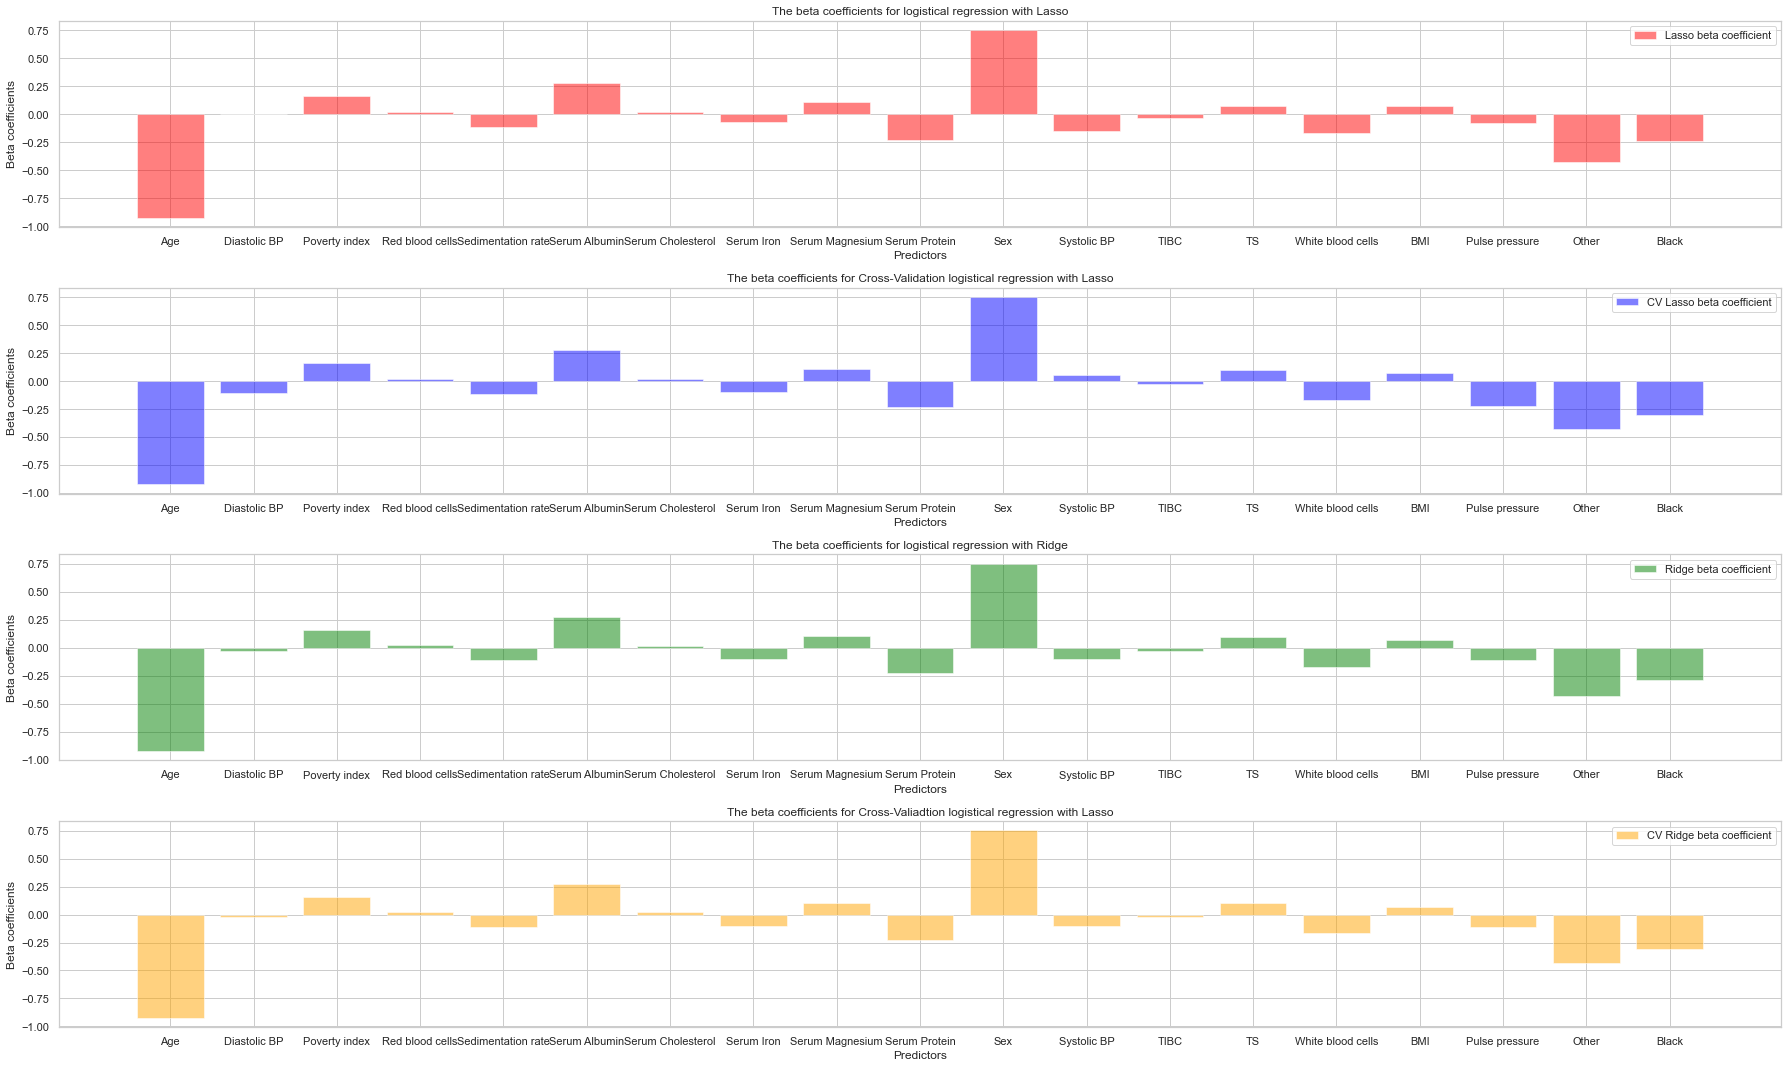

In [14]:
fig, axes = plt.subplots(4,1, figsize = (25, 15))

axes[0].bar(x=X_train.columns, height = beta_coef_lasso, alpha = 0.5, color = "red")
axes[1].bar(x=X_train.columns, height = beta_coef_lasso_CV, alpha = 0.5, color = "blue")
axes[2].bar(x=X_train.columns, height = beta_coef_ridge, alpha = 0.5, color = "green")
axes[3].bar(x=X_train.columns, height = beta_coef_ridge_CV, alpha = 0.5, color = "orange")

axes[0].legend(["Lasso beta coefficient"]);
axes[1].legend(["CV Lasso beta coefficient"]);
axes[2].legend(["Ridge beta coefficient"]);
axes[3].legend(["CV Ridge beta coefficient"]);

axes[0].set_title("The beta coefficients for logistical regression with Lasso")
axes[0].set_xlabel("Predictors")
axes[0].set_ylabel("Beta coefficients")

axes[1].set_title("The beta coefficients for Cross-Validation logistical regression with Lasso")
axes[1].set_xlabel("Predictors")
axes[1].set_ylabel("Beta coefficients")

axes[2].set_title("The beta coefficients for logistical regression with Ridge")
axes[2].set_xlabel("Predictors")
axes[2].set_ylabel("Beta coefficients")

axes[3].set_title("The beta coefficients for Cross-Valiadtion logistical regression with Lasso")
axes[3].set_xlabel("Predictors")
axes[3].set_ylabel("Beta coefficients")

plt.tight_layout()

plt.savefig("Ray/Beta_Coefs", bbox_inches = "tight")
plt.show()
plt.clf()
plt.close()

### <div class='exercise'> Single Decision Tree (CV) Performance </div>
---

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

depths = list(range(1, 51))

def calc_meanstd(X_train, y_train, depths):
    train_scores = []
    cvmeans = []
    cvstds = []
    cv_score_tracker = {}
    
    for depth in depths:
        dtree = DecisionTreeClassifier(max_depth=depth)
        dtree.fit(X_train, y_train)
        train_score = dtree.score(X_train, y_train)
        scores = cross_val_score(dtree, X_train, y_train, cv=5, scoring="roc_auc")
        train_scores.append(train_score)
        cvmeans.append(scores.mean())
        cvstds.append(scores.std())
        cv_score_tracker[depth] = scores.mean()
        
    cvmeans = np.array(cvmeans)
    cvstds = np.array(cvstds)
    
    return cvmeans, cvstds, train_scores, cv_score_tracker

cvmeans, cvstds, train_scores, scores_dict = calc_meanstd(X_train_impute, y_train.values.ravel(), depths)


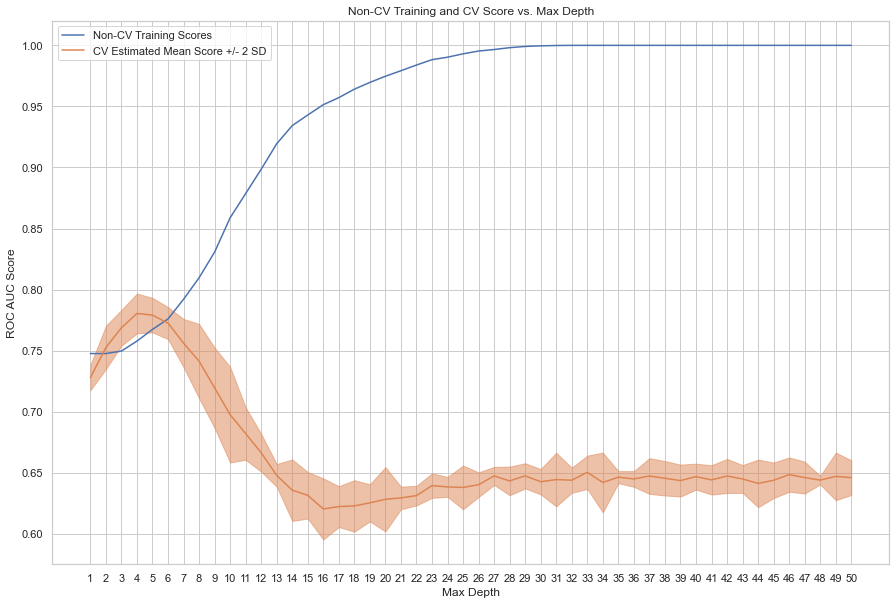

In [16]:
plt.figure(figsize=(15,10))
plt.plot(depths, train_scores, label="Non-CV Training Scores")
plt.plot(depths, cvmeans, label="CV Estimated Mean Score +/- 2 SD")
plt.fill_between(depths, cvmeans - 2*cvstds, cvmeans + 2*cvstds, color="C1", alpha=0.5)
plt.legend()
plt.title("Non-CV Training and CV Score vs. Max Depth")
plt.ylabel("ROC AUC Score")
plt.xlabel("Max Depth")
plt.xticks(depths);
plt.savefig("Single_Tree_Plots/Tree CV Training", bbox_inches = "tight")


In [17]:
best_depth = max(scores_dict, key=scores_dict.get)
dtree = DecisionTreeClassifier(max_depth=best_depth).fit(X_train_impute, y_train.values.ravel())
y_pred_train = dtree.predict(X_train_impute)
y_pred_test = dtree.predict(X_test_impute)

best_cv_tree_train_score = roc_auc_score(y_train, y_pred_train)
best_cv_tree_test_score = roc_auc_score(y_test, y_pred_test)
print(f"Best CV Tree Train Score: {best_cv_tree_train_score}")
print(f"Best CV Tree Test Score: {best_cv_tree_test_score}")
print(f"Best Depth: {best_depth}")
                                        

Best CV Tree Train Score: 0.7282631878595492
Best CV Tree Test Score: 0.7088957316230045
Best Depth: 4


<Figure size 432x288 with 0 Axes>

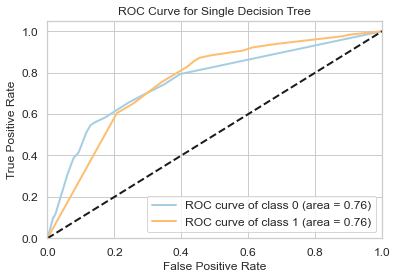

In [18]:
import scikitplot as skplt

fig = plt.figure();
y_probas = dtree.predict_proba(X_test_impute);
skplt.metrics.plot_roc(y_test, y_probas, plot_micro=False, plot_macro=False, cmap="Paired");
plt.title("ROC Curve for Single Decision Tree");
plt.savefig("Single_Tree_Plots/ROC Curve Single Decision Tree", bbox_inches = "tight")
plt.show();

### <div class='exercise'> Single Decision Tree Interpretation </div>

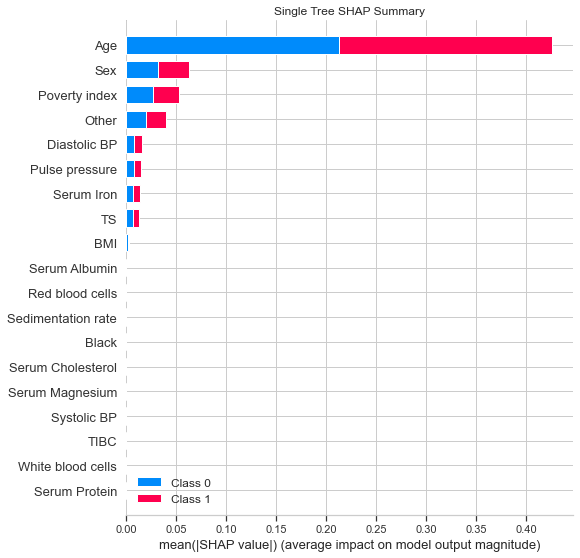

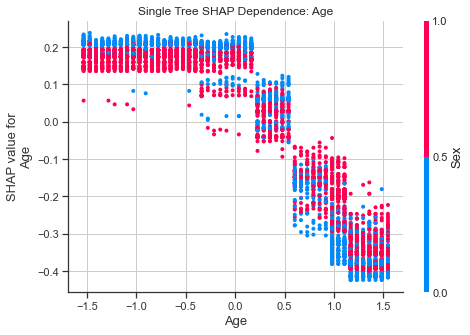

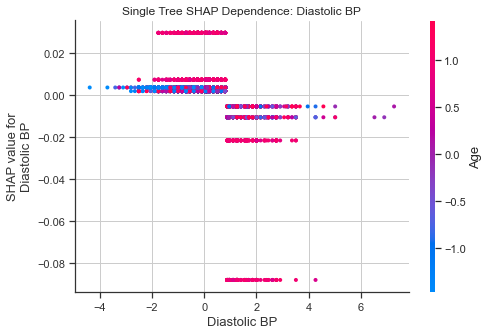

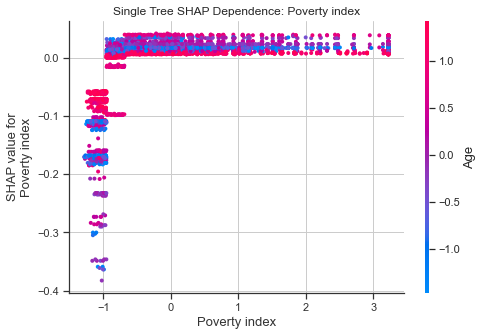

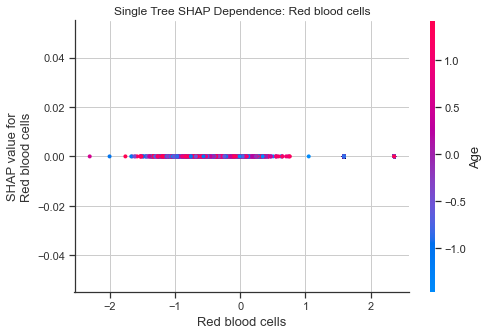

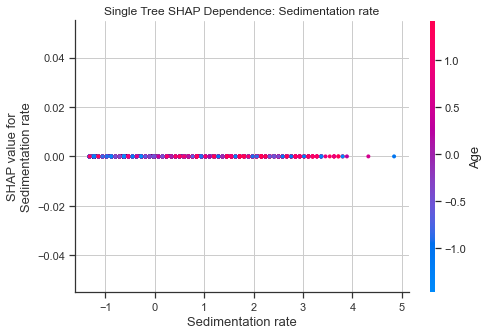

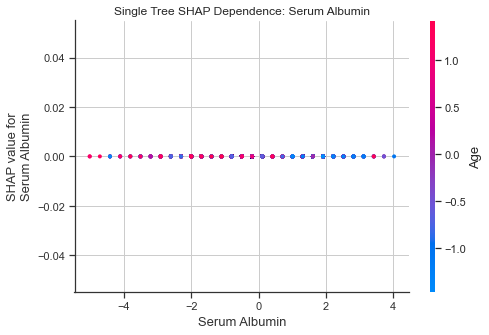

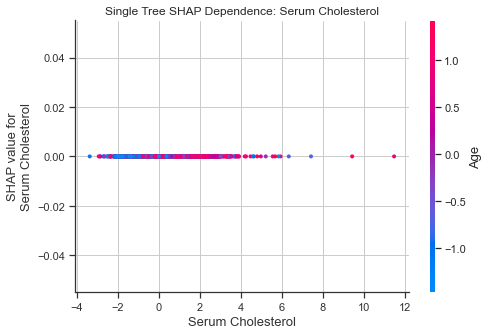

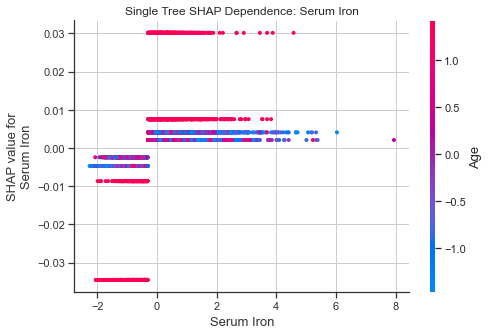

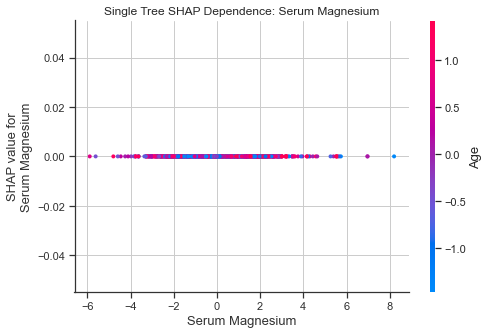

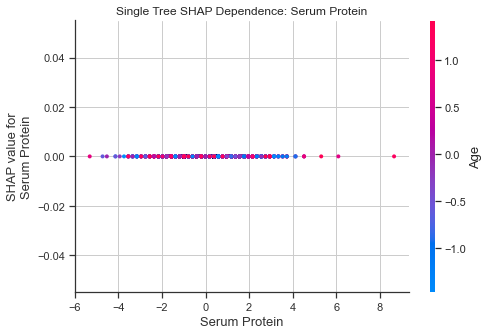

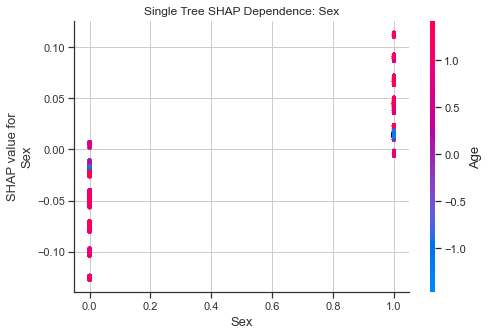

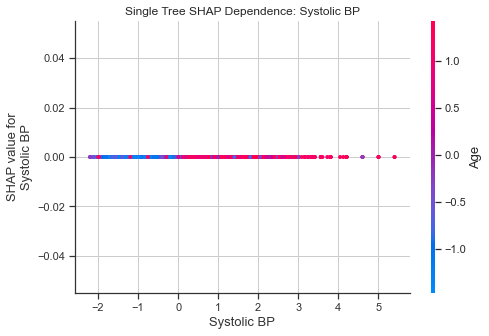

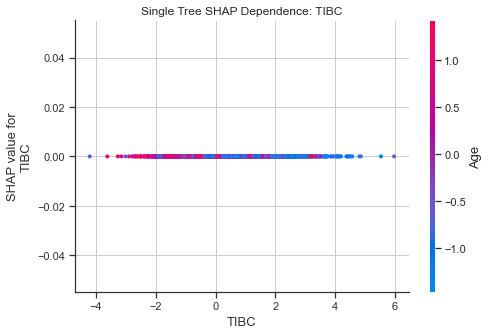

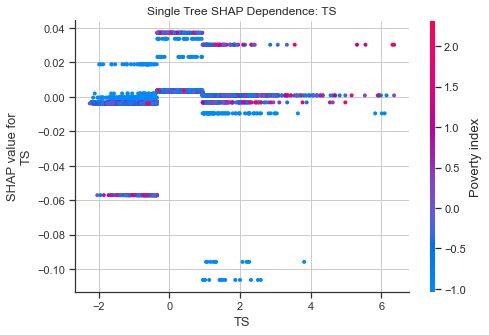

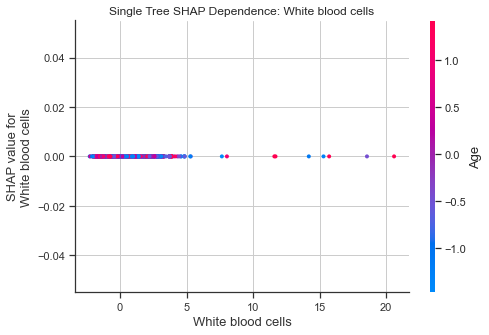

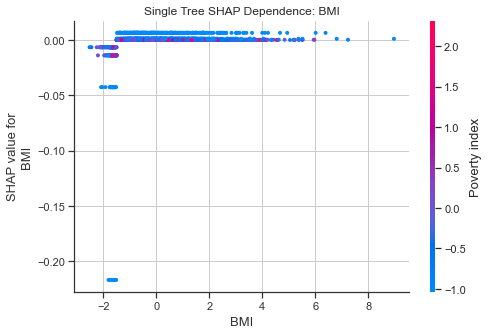

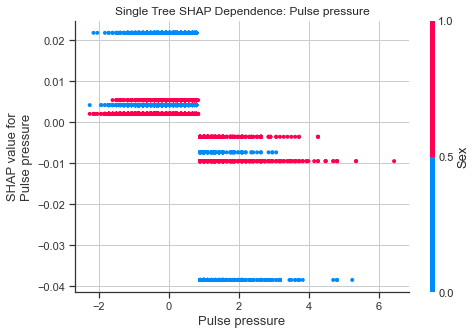

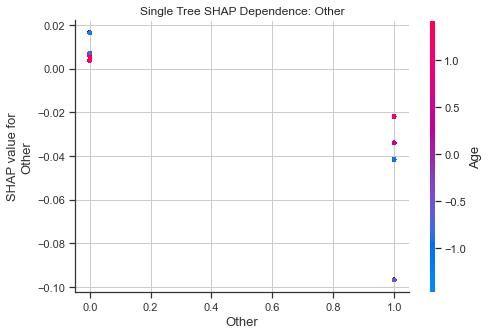

In [19]:
shap_values = shap.TreeExplainer(dtree).shap_values(X_train_impute)
shap.summary_plot(shap_values, X_train_impute, plot_type="bar", show=False)
plt.title("Single Tree SHAP Summary")
plt.savefig(f"Single_Tree_Plots/Single_Tree_SHAP_Summary", bbox_inches = "tight");

for i in range(18):
    shap.dependence_plot(X_train.columns[i], shap_values[1], X_train_impute, show=False);
    plt.title(f"Single Tree SHAP Dependence: {X_train.columns[i]}")
    plt.savefig(f"Single_Tree_Plots/Single_Tree_SHAP_Dependence_{X_train.columns[i]}", bbox_inches = "tight");
    

<Figure size 432x288 with 0 Axes>

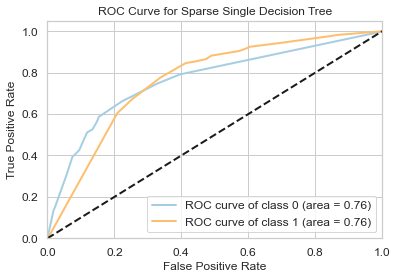

Sparse Tree Score: 0.7070125615580161


In [20]:
skim_tree = dtree.fit(X_train_impute[['Age', 'Sex', 'Poverty index', 'Other']], y_train.values.ravel())
skim_pred = skim_tree.predict(X_test_impute[['Age', 'Sex', 'Poverty index', 'Other']])
skim_score = roc_auc_score(y_test, skim_pred)

fig = plt.figure();
y_probas = skim_tree.predict_proba(X_test_impute[['Age', 'Sex', 'Poverty index', 'Other']]);
skplt.metrics.plot_roc(y_test, y_probas, plot_micro=False, plot_macro=False, cmap="Paired");
plt.title("ROC Curve for Sparse Single Decision Tree");
plt.savefig("Single_Tree_Plots/Sparse ROC Curve Single Decision Tree", bbox_inches = "tight")
plt.show();

print(f"Sparse Tree Score: {skim_score}")

### <div class='exercise'> Decision Trees with Bagging </div>
---

In [21]:
param_grid = {'base_estimator__max_depth' : range(1,11), 
              'n_estimators' : [1,2,3,4,5,10,20,50,100]}

bagging_grid = GridSearchCV(BaggingClassifier(DecisionTreeClassifier()),
                                              param_grid, scoring = "roc_auc",verbose=1)

bagging_grid.fit(X_train_impute, y_train.values.ravel())
bagging_grid_best = bagging_grid.best_estimator_
bagging_best_params = bagging_grid.best_params_

y_pred_train = bagging_grid_best.predict(X_train_impute)
y_pred_test = bagging_grid_best.predict(X_test_impute)
bagging_model_train_accuracy = roc_auc_score(y_train, y_pred_train)
bagging_model_test_accuracy = roc_auc_score(y_test, y_pred_test)
print(f"Best Grid Search Bagging Model Score on Train: {bagging_model_train_accuracy}")
print(f"Best Grid Search Bagging Model Score on Test: {bagging_model_test_accuracy}")
print(f"Best Hyperparameters: {bagging_best_params}")


Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  2.5min finished


Best Grid Search Bagging Model Score on Train: 0.7667867952893578
Best Grid Search Bagging Model Score on Test: 0.7250305795760341
Best Hyperparameters: {'base_estimator__max_depth': 6, 'n_estimators': 100}


<Figure size 432x288 with 0 Axes>

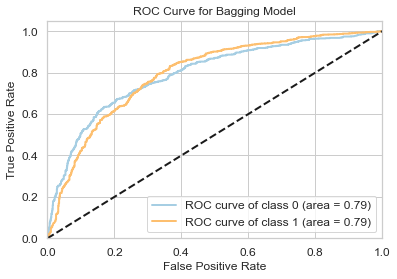

In [22]:
fig = plt.figure();
y_probas = bagging_grid_best.predict_proba(X_test_impute);
skplt.metrics.plot_roc(y_test, y_probas, plot_micro=False, plot_macro=False, cmap="Paired");
plt.title("ROC Curve for Bagging Model");
plt.savefig("Bagging/Bagging ROC Curve", bbox_inches = "tight")
plt.show();

### <div class='exercise'> Bagging Model Interpretation </div>

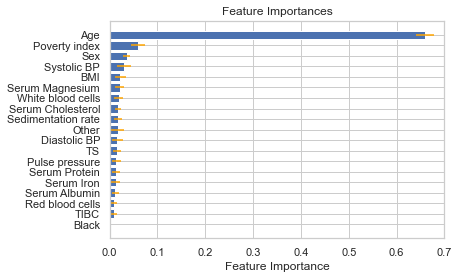

In [23]:
importances = np.mean([tree.feature_importances_ for tree in bagging_grid_best.estimators_], axis=0)
std = np.std([tree.feature_importances_ for tree in bagging_grid_best.estimators_], axis=0)
indices = np.argsort(importances)

features = X_train_impute.columns
plt.barh(range(len(indices)), importances[indices], color='b', 
         xerr=std[indices], align='center', ecolor='orange')
plt.title('Feature Importances')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.xlim(0, 0.7)
plt.savefig(f"Bagging/Bagging Feature_importances", bbox_inches = "tight");
plt.show()

In [24]:
r = permutation_importance(bagging_grid_best, X_test_impute, y_test.values.ravel(), n_repeats=15)                           

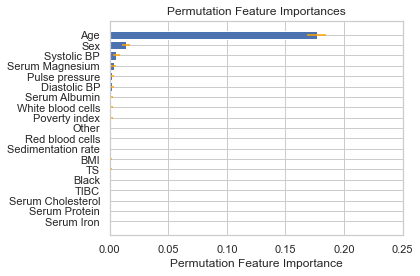

In [25]:
indices = np.argsort(r.importances_mean)
std = r.importances_std

fig = plt.figure()
plt.barh(range(len(indices)), r.importances_mean[indices], color='b', 
         align='center', xerr=std[indices], ecolor="orange")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.title('Permutation Feature Importances')
plt.xlabel('Permutation Feature Importance')
plt.xlim(0, 0.25)
fig.tight_layout()
plt.savefig(f"Bagging/Bagging Permuation_importances", bbox_inches = "tight");
plt.show()


### <div class="exercise"> Boosting </div>

Text(0, 0.5, 'Staged Score')

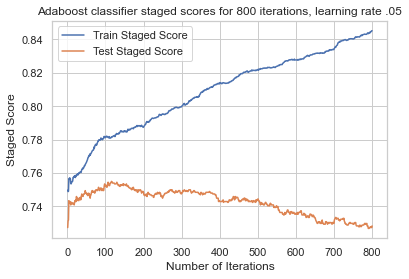

In [26]:
from sklearn.ensemble import AdaBoostClassifier

boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.05, n_estimators=800)
boost.fit(X_train_impute, y_train.values.ravel())

boost_train_staged_score = list(boost.staged_score(X_train_impute,y_train.values.ravel()))
boost_test_staged_score = list(boost.staged_score(X_test_impute,y_test.values.ravel()))

plt.plot(range(1,801), boost_train_staged_score, label = "Train Staged Score")
plt.plot(range(1,801), boost_test_staged_score, label = "Test Staged Score")
plt.title("Adaboost classifier staged scores for 800 iterations, learning rate .05")
plt.legend()
plt.xlabel("Number of Iterations")
plt.ylabel("Staged Score")

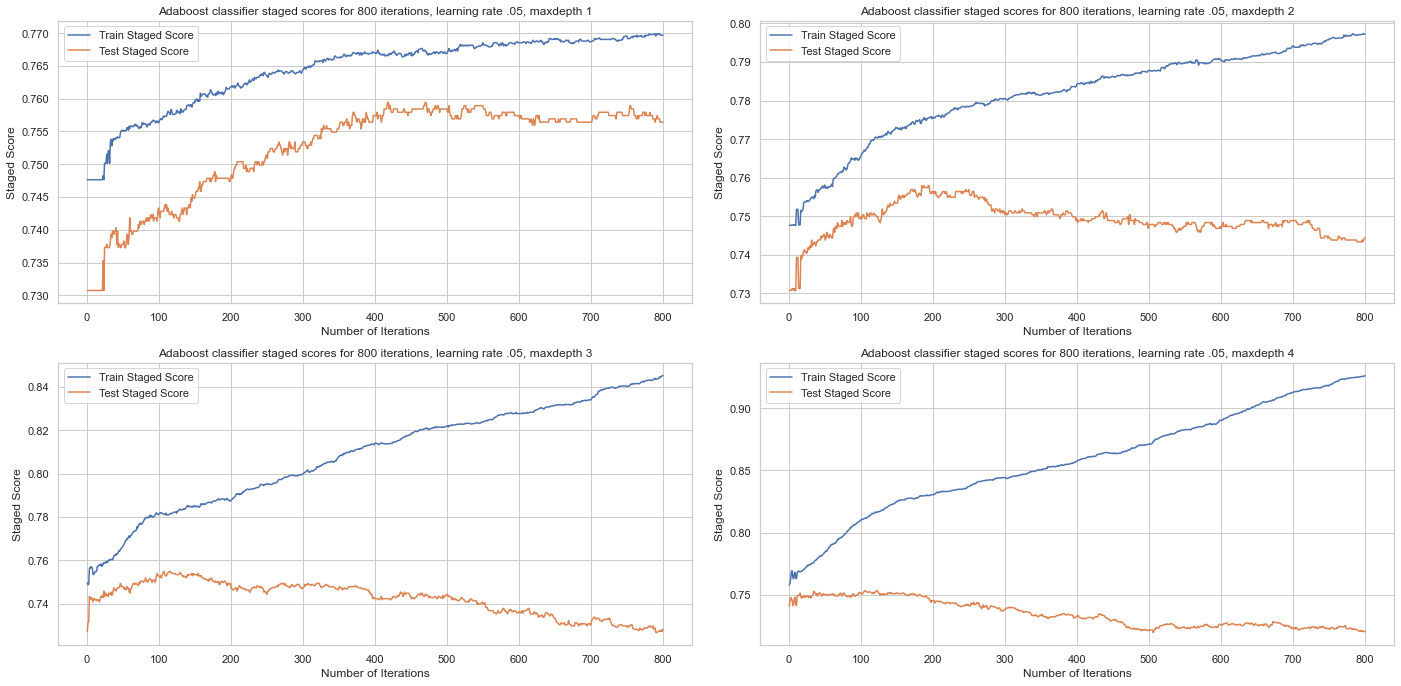

In [27]:
depths = [1,2,3,4]
fig, axs = plt.subplots(2,2, figsize=(20,10))

fig.tight_layout(pad=3.0)
axs = axs.ravel()

for i in range(len(depths)):
    boost = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=depths[i]), learning_rate=0.05, n_estimators=800)
    boost.fit(X_train_impute,y_train.values.ravel())

    boost_train_staged_score = list(boost.staged_score(X_train_impute,y_train.values.ravel()))
    boost_test_staged_score = list(boost.staged_score(X_test_impute,y_test.values.ravel()))

    axs[i].plot(range(1,801), boost_train_staged_score, label = "Train Staged Score")
    axs[i].plot(range(1,801), boost_test_staged_score, label = "Test Staged Score")
    axs[i].set_title("Adaboost classifier staged scores for 800 iterations, learning rate .05, maxdepth " + str(depths[i]))
    axs[i].legend()
    axs[i].set_xlabel("Number of Iterations")
    axs[i].set_ylabel("Staged Score")


In [28]:
boost_depth3 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), learning_rate=0.05, n_estimators=120)
boost_depth3.fit(X_train_impute,y_train.values.ravel())

y_train_pred = boost_depth3.predict(X_train_impute)
boost_depth3_train_score = roc_auc_score(y_train_pred, y_train)
y_test_pred = boost_depth3.predict(X_test_impute)
boost_depth3_test_score = roc_auc_score(y_test_pred, y_test)

print(f"Depth 3 Boosting Model Training Score: {boost_depth3_train_score}") 
print(f"Depth 3 Boosting Model Testing Score: {boost_depth3_test_score}") 

Depth 3 Boosting Model Training Score: 0.7759288198770287
Depth 3 Boosting Model Testing Score: 0.7458697243173733


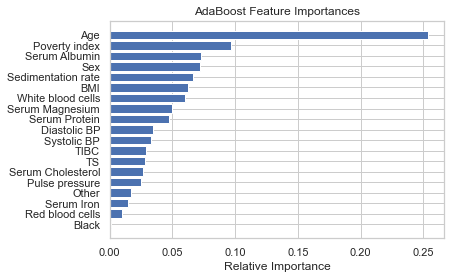

In [29]:
features = X_train.columns
importances = boost_depth3.feature_importances_
indices = np.argsort(importances)

plt.title("AdaBoost Feature Importances")
plt.barh(range(len(indices)), importances[indices], color = "b", align = "center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [30]:
from sklearn.inspection import permutation_importance
features = X_train.columns
importances = permutation_importance(boost_depth3, X_train_impute, y_train)
indices = np.argsort(importances['importances_mean'])

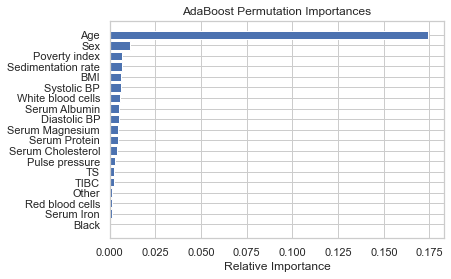

In [31]:
plt.title("AdaBoost Permutation Importances")
plt.barh(range(len(indices)), importances['importances_mean'][indices], color = "b", align = "center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [32]:
import xgboost
xgboost_full = xgboost.XGBClassifier(n_estimators=120, use_label_encoder=False, learning_rate=0.05, max_depth=3, eval_metric='error').fit(X_train_impute, y_train.values.ravel())

In [33]:
# How well can we predict survivability?
y_test_pred = xgboost_full.predict(X_test_impute, ntree_limit=5000)
print(f"ROC AUC Score: {roc_auc_score(y_test_pred, y_test)}")

ROC AUC Score: 0.7450507843500496


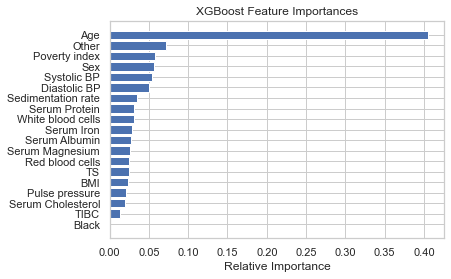

In [34]:
features = X_train.columns
importances = xgboost_full.feature_importances_
indices = np.argsort(importances)

plt.title("XGBoost Feature Importances")
plt.barh(range(len(indices)), importances[indices], color = "b", align = "center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.savefig("Vineet/Boosting_Feature_Importance", bbox_inches = "tight")
plt.show()

In [35]:
features = X_train.columns
importances = permutation_importance(xgboost_full, X_train_impute, y_train)
indices = np.argsort(importances['importances_mean'])

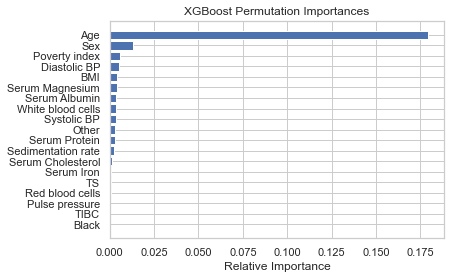

In [36]:
plt.title("XGBoost Permutation Importances")
plt.barh(range(len(indices)), importances['importances_mean'][indices], color = "b", align = "center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.savefig("Vineet/Boost_Permutation", bbox_inches = "tight")
plt.show()

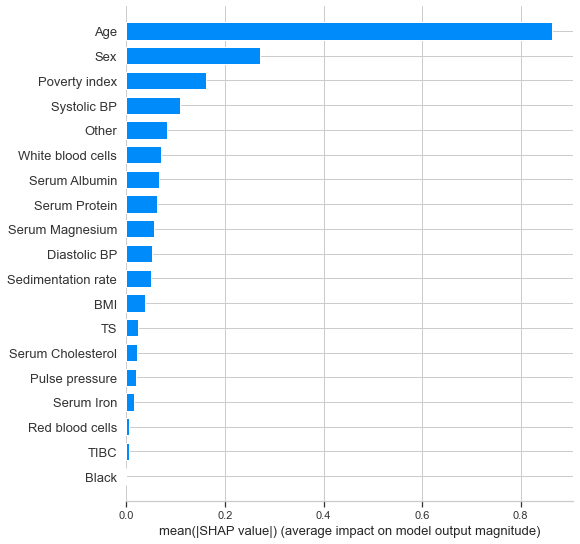

In [37]:
import shap
X_train_impute_shap = pd.DataFrame(X_train_impute, columns = X_train.columns)
X_test_impute_shap = pd.DataFrame(X_test_impute, columns = X_train.columns)
shap_values_xgboost = shap.TreeExplainer(xgboost_full).shap_values(X_train_impute_shap)
shap.summary_plot(shap_values_xgboost, X_train, plot_type="bar", alpha=0.5, show=False)
plt.savefig("Vineet/SHAP_summary_Boost", bbox_inches = "tight")

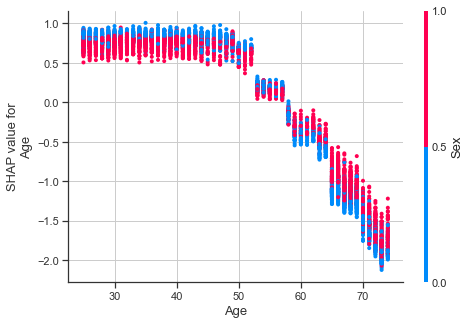

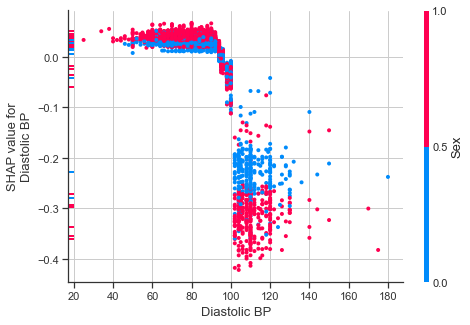

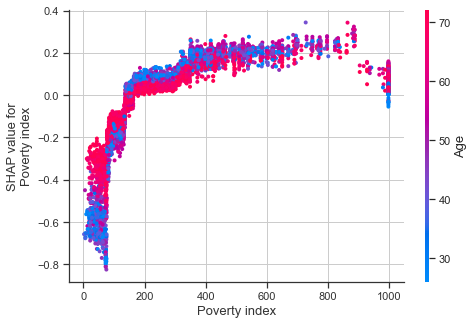

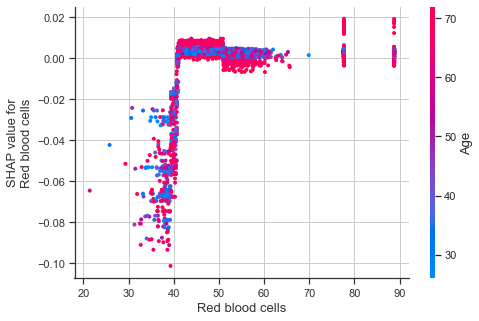

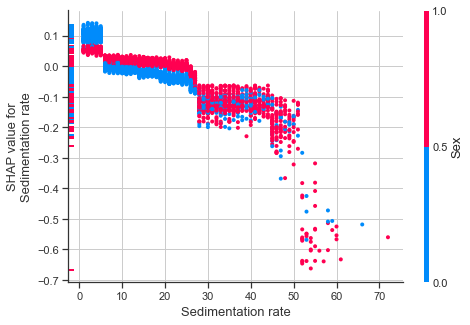

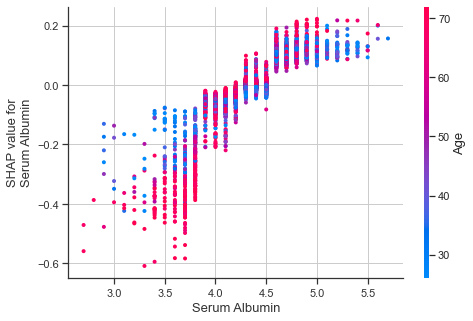

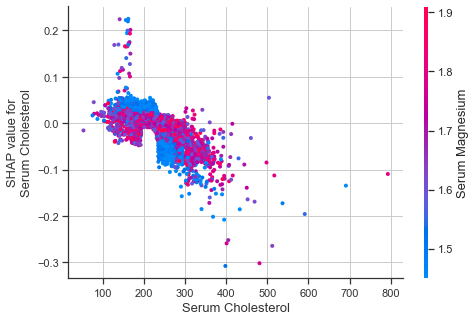

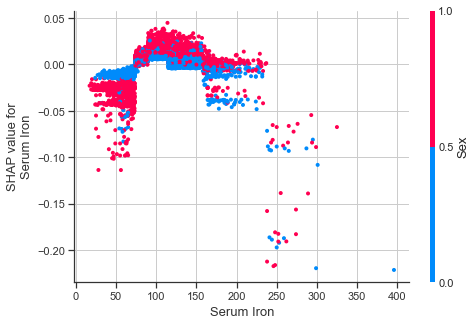

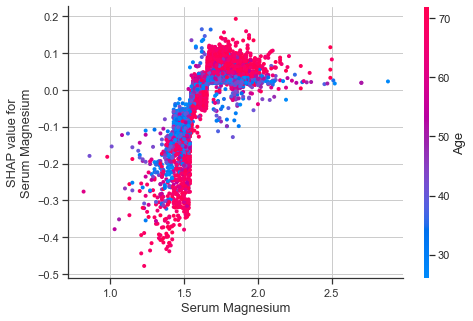

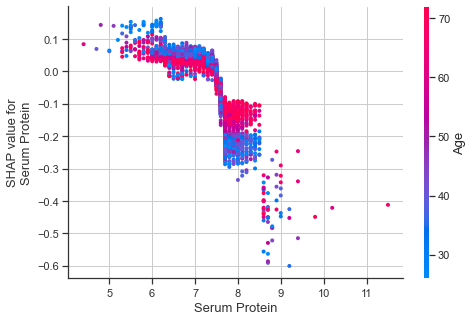

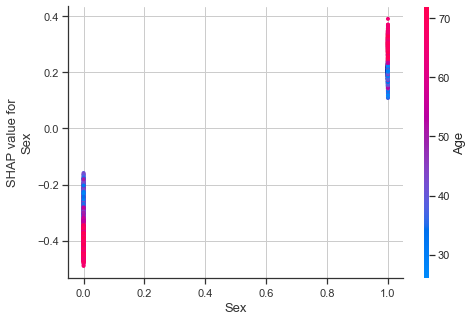

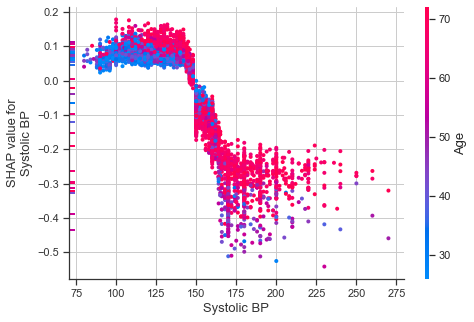

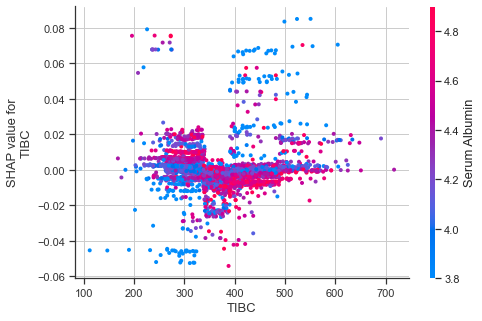

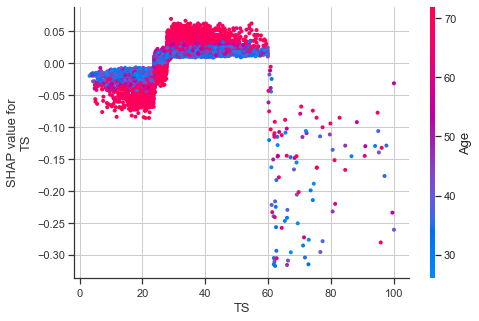

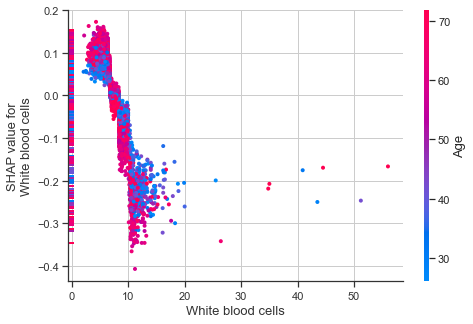

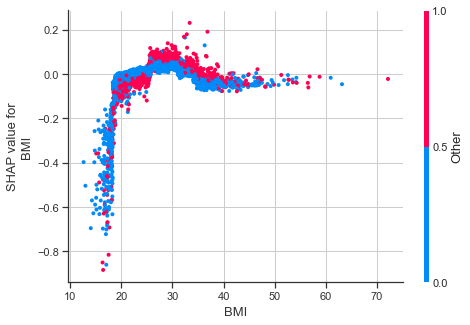

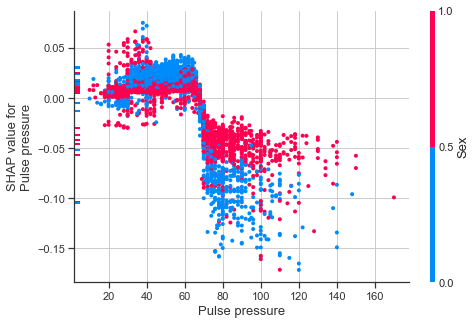

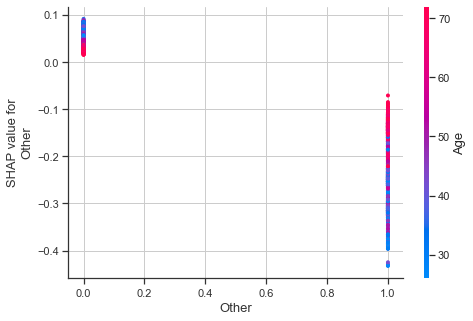

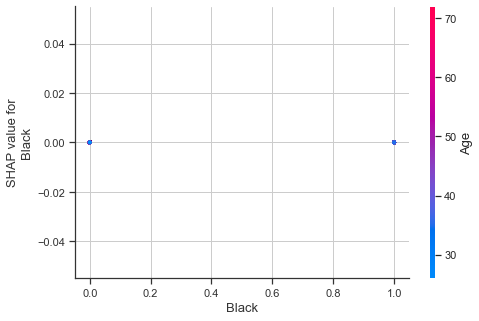

In [38]:
for i in X_train.columns:
    shap.dependence_plot(i, shap_values_xgboost, X_train)

In [39]:
# The top 4 features are Age, Sex, Poverty Index, and Systolic BP
top4 = ['Age', 'Sex', "Poverty index", 'Systolic BP']
xgboost_top4 = xgboost.XGBClassifier(n_estimators=150, use_label_encoder=False, learning_rate=0.05, max_depth=4,eval_metric='error').fit(X_train_impute_shap[top4], y_train.values.ravel())

y_test_pred = xgboost_top4.predict(X_test_impute_shap[top4], ntree_limit=5000)
print(roc_auc_score(y_test_pred, y_test))

0.7379747991656761


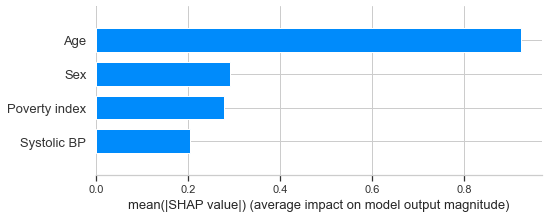

In [40]:
shap_values_xgboost = shap.TreeExplainer(xgboost_top4).shap_values(X_train_impute_shap[top4])
shap.summary_plot(shap_values_xgboost, X_train_impute_shap[top4], plot_type="bar", alpha=0.5)

In [44]:
# Remove Age to investigate its importance in the boosting model
X_train_impute_no_age = X_train_impute_shap.drop("Age", axis=1)
X_test_impute_no_age = X_test_impute_shap.drop("Age", axis=1)
xgboost_no_age = xgboost.XGBClassifier(n_estimators=120, use_label_encoder=False, learning_rate=0.05, max_depth=3, eval_metric='error').fit(X_train_impute_no_age, y_train.values.ravel())

y_test_pred = xgboost_no_age.predict(X_test_impute_no_age, ntree_limit=5000)
print(f"ROC AUC Score after removing Age feature: {roc_auc_score(y_test_pred, y_test)}")

ROC AUC Score after removing Age feature: 0.6926122750403081


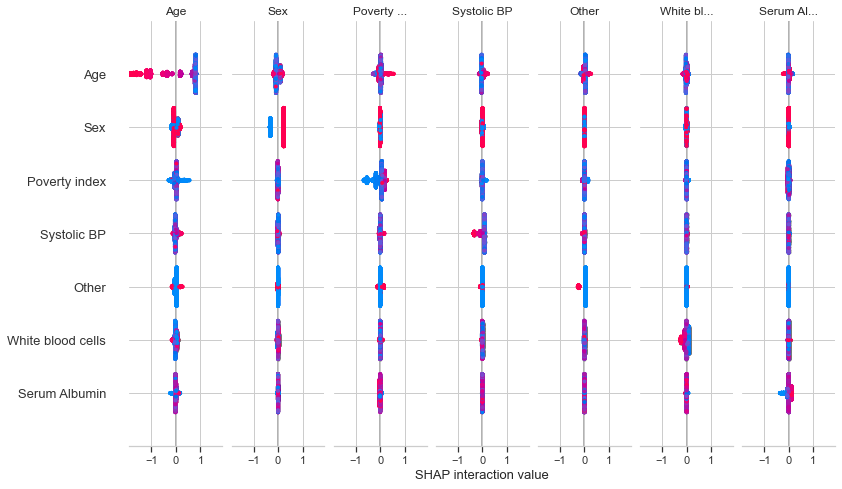

In [45]:
shap_interaction_values = shap.TreeExplainer(xgboost_full).shap_interaction_values(X_train_impute_shap)
shap.summary_plot(shap_interaction_values, X_train)

The plot below involving age and sex shows that the sex-based death risk within 18 years gap varies by age and peaks at age 65 with males having a lower chance of surviving for 18 years. The plot of Age and Poverty Index shows that the survival within 18 years varies by age and reflects that at higher ages, a lower poverty index relates to increased survival for at least 18 years. This is likely because lower indexed people die at a young age due to poverty-related factors (i.e. low access to healthcare), so those who do survive to an older age likely have some outside factor (such as really strong immune system) that sets them apart. The plot of Age and Systolic BP reflects that at high ages, some observations with higher Systolic BP had higher predicted probability of survival for at least 18 years. This can be explained via field research done via various studies, such as one that concluded "older frail adults might benefit from slightly higher blood pressure.” 

The plot for sex and systolic BP reflects that higher BP males and lower BP females have higher predicted survival than their counterparts. 

https://www.health.harvard.edu/blog/blood-pressure-goals-may-need-to-change-with-age-201207205034

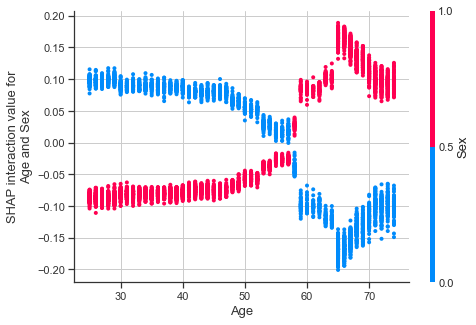

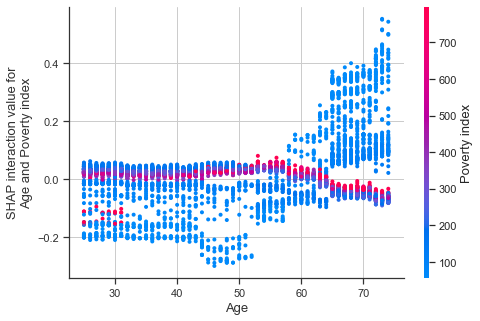

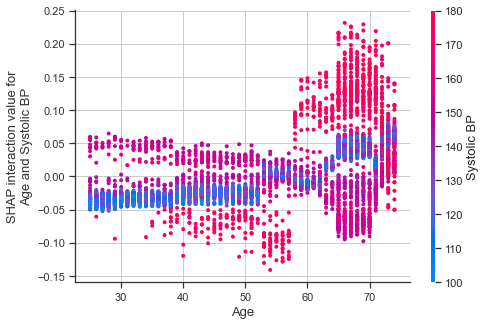

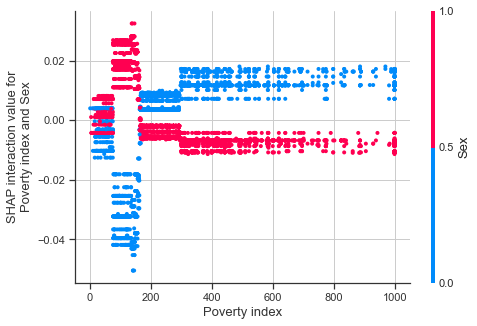

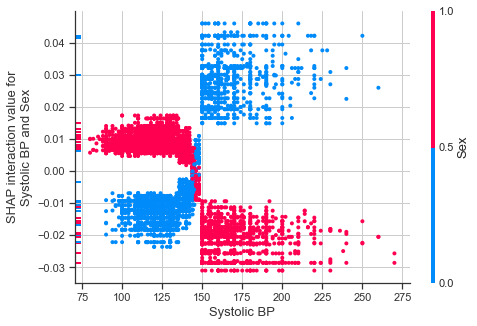

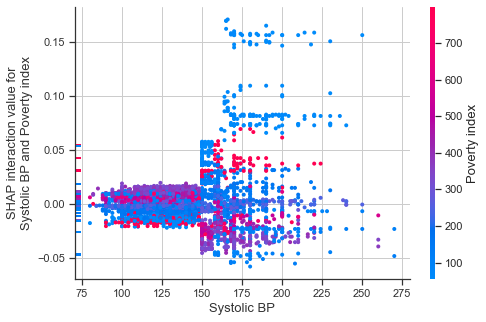

In [46]:
shap.dependence_plot( ("Age", "Sex"),shap_interaction_values, X_train, show=False)
plt.savefig('Vineet/shap_age_sex', bbox_inches = "tight")
shap.dependence_plot( ("Age", "Poverty index"),shap_interaction_values, X_train,show=False)
plt.savefig('Vineet/shap_age_pov', bbox_inches = "tight")
shap.dependence_plot( ("Age", "Systolic BP"),shap_interaction_values, X_train,show=False)
plt.savefig('Vineet/shap_age_BP', bbox_inches = "tight")
shap.dependence_plot( ("Poverty index","Sex",),shap_interaction_values, X_train,show=False)
plt.savefig('Vineet/shap_pov_sex', bbox_inches = "tight")
shap.dependence_plot( ('Systolic BP',"Sex"),shap_interaction_values, X_train,show=False)
plt.savefig('Vineet/shap_BP_sex', bbox_inches = "tight")
shap.dependence_plot( ('Systolic BP',"Poverty index"),shap_interaction_values, X_train,show=False)
plt.savefig('Vineet/shap_BP_pov', bbox_inches = "tight")

### <div class="exercise"> Minimal Explaining Feature Subsets: Reduced Feature Sets Capturing the Essence of the Data </div>

In [47]:
demographic = ['Age', 'Black', "Poverty index", 'Other', 'Sex']
xgboost_demo = xgboost.XGBClassifier(n_estimators=150, use_label_encoder=False, learning_rate=0.05, max_depth=4,eval_metric='error').fit(X_train_impute_shap[demographic], y_train.values.ravel())

y_test_pred = xgboost_demo.predict(X_test_impute_shap[demographic], ntree_limit=5000)
print(f"Using a subset of 'Age', 'Black', 'Poverty index', 'Other', and 'Sex', we get a score of: {roc_auc_score(y_test_pred, y_test)}")

Using a subset of 'Age', 'Black', 'Poverty index', 'Other', and 'Sex', we get a score of: 0.7299440729757461


In [48]:
Serums = ['Serum Albumin', 'Serum Cholesterol', "Serum Iron", 'Serum Magnesium', 'Serum Protein']
xgboost_serum = xgboost.XGBClassifier(n_estimators=150, use_label_encoder=False, learning_rate=0.05, max_depth=4,eval_metric='error').fit(X_train_impute_shap[Serums], y_train.values.ravel())

y_test_pred = xgboost_serum.predict(X_test_impute_shap[Serums], ntree_limit=5000)
print(f"Using a subset of Serum features, we get a score of: {roc_auc_score(y_test_pred, y_test)}")

Using a subset of Serum features, we get a score of: 0.6231048864340867


In [49]:
Iron = ['Serum Iron', 'TS','TIBC']
xgboost_iron = xgboost.XGBClassifier(n_estimators=150, use_label_encoder=False, learning_rate=0.05, max_depth=4,eval_metric='error').fit(X_train_impute_shap[Iron], y_train.values.ravel())

y_test_pred = xgboost_iron.predict(X_test_impute_shap[Iron], ntree_limit=5000)
print(f"Using a subset of iron-related features, get a score of: {roc_auc_score(y_test_pred, y_test)}")

Using a subset of iron-related features, get a score of: 0.5956649632842359


### <div class="exercise"> Random Forest </div>

In [50]:
# # Grid Search with 5-fold cross-validation
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# hyperF = dict(n_estimators = [500], max_depth = [5, 8, 15, 25, 35],
#             min_samples_split = [2, 5, 10, 15, 50])
# gridF = GridSearchCV(RandomForestClassifier(random_state = 109), hyperF, cv = 5, verbose = 1, n_jobs = -1)
# bestF = gridF.fit(X_train_impute, y_train.values.ravel())
# bestF.best_estimator_

# Results in min_samples_split = 50 and max_depth = 15


In [51]:
from sklearn.ensemble import RandomForestClassifier

# fit the random forest with extracted hyperparameters
rf = RandomForestClassifier(n_estimators = 500, max_depth = 15, min_samples_split = 15, random_state = 109)
rf.fit(X_train_impute, y_train.values.ravel())

# test accuracy
y_pred = rf.predict(X_test_impute)
rf_test_accuracy = roc_auc_score(y_test, y_pred)


In [52]:
print(f"Random Forest Test Score is: {rf_test_accuracy}")

Random Forest Test Score is: 0.7325760234851144


In [ ]:
shap_values_dtree = shap.TreeExplainer(rf).shap_values(X_train_impute)
shap.summary_plot(shap_values_dtree, X_train_impute, plot_type="bar", alpha=0.5, show=False)
plt.savefig("Sean/SHAP_RF_Summary", bbox_inches = "tight")

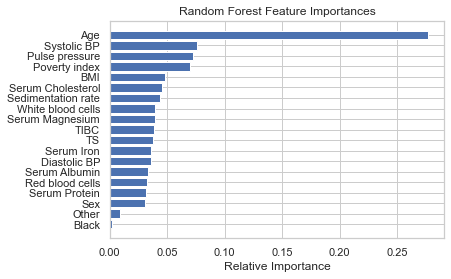

In [56]:
features = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title("Random Forest Feature Importances")
plt.barh(range(len(indices)), importances[indices], color = "b", align = "center")
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.savefig("Sean/RF_Feature_Importance", bbox_inches = "tight")
plt.show()

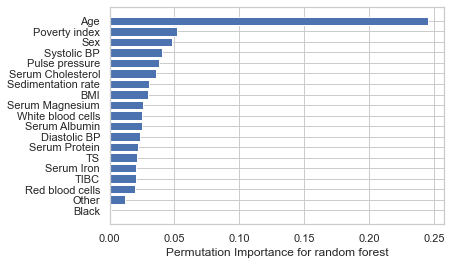

In [55]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rf, X_train_impute, y_train)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance for random forest")
plt.savefig("Sean/RF_Permutation_Importance", bbox_inches = "tight")
plt.show()